# DBSCAN

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler 

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 

%matplotlib inline


In [2]:
def experiment_number_of_clusters(X, clustering, show_metric=True,
                                  plot_data=True, plot_centers=True, plot_boundaries=False):
    plt.figure(figsize=(15,6))
    for n_clusters in range(2,10):
        clustering.n_clusters = n_clusters
        y = clustering.fit_predict(X)

        cm = plt.cm.plasma
        plt.subplot(2,4,n_clusters-1)

        plot_cluster_predictions(clustering, X, n_clusters, cm, 
                                 plot_data, plot_centers, show_metric)
        
def plot_cluster_predictions(clustering, X, n_clusters = None, cmap = plt.cm.plasma,
                             plot_data=True, plot_centers=True, show_metric=False,
                             title_str=""):

    assert not hasattr(clustering, "n_clusters") or \
           (hasattr(clustering, "n_clusters") and n_clusters is not None), "must specify `n_clusters` for "+str(clustering)

    if n_clusters is not None:
        clustering.n_clusters = n_clusters

    y = clustering.fit_predict(X)
    # remove elements tagged as noise (cluster nb<0)
    X = X[y>=0]
    y = y[y>=0]

    if n_clusters is None:
        n_clusters = len(np.unique(y))

    if plot_data:        
        plt.scatter(X[:,0], X[:,1], color=cmap((y*255./(n_clusters-1)).astype(int)), alpha=.5)
    if plot_centers and hasattr(clustering, "cluster_centers_"):
        plt.scatter(clustering.cluster_centers_[:,0], clustering.cluster_centers_[:,1], s=150,  lw=3,
                    facecolor=cmap((np.arange(n_clusters)*255./(n_clusters-1)).astype(int)),
                    edgecolor="black")   

    if show_metric:
        if hasattr(clustering, 'inertia_'):
          inertia = clustering.inertia_
        else:
          inertia = 0
        sc = silhouette_score(X, y) if len(np.unique(y))>1 else 0
        plt.title("n_clusters %d, inertia=%.0f sc=%.3f"%(n_clusters, inertia, sc)+title_str)
    else:
        plt.title("n_clusters %d"%n_clusters+title_str)

    plt.axis("off")
    return

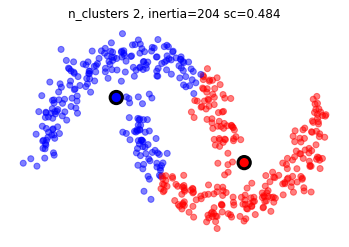

In [3]:
X,_ = make_moons(500, noise=.1)
plot_cluster_predictions(KMeans(), X, n_clusters=2,cmap=plt.cm.bwr, show_metric=True)

When clusters are not globular, other methods can produce better results.

## Density based methods - DBSCAN

You need to specify $ \epsilon $ (maximum radius of a neighborhood) and `min_samples`.

How does the silhouette metric behave? what metric would you use?

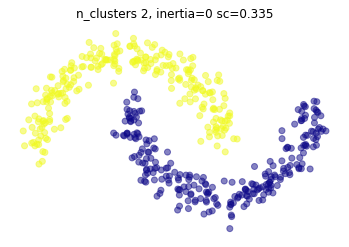

In [4]:
X,_ = make_moons(500, noise=.1)
dbs = DBSCAN(eps=.15, min_samples=4, metric='euclidean')
plot_cluster_predictions(dbs, X, cmap=plt.cm.plasma, show_metric=True)

very sensitive to $ \epsilon $. also note that the silhouette metric is very sensitive to outliers.

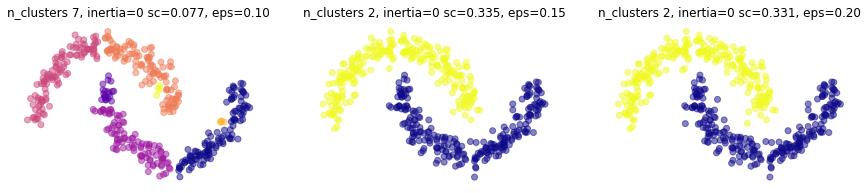

In [5]:
plt.figure(figsize=(15,3))
for i,eps in enumerate([.1,.15,.2]):
    plt.subplot(1,3,i+1)
    plot_cluster_predictions(DBSCAN(eps=eps, min_samples=4, metric='euclidean'), X, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", eps=%.2f"%eps)


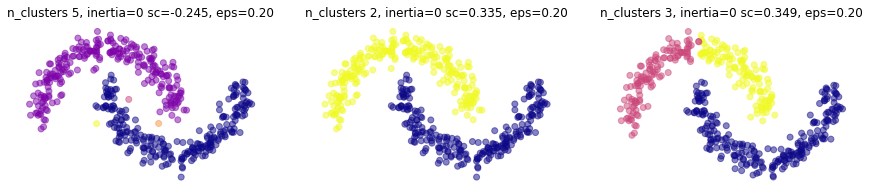

In [6]:
plt.figure(figsize=(15,3))
for i,min_samples in enumerate([1,4,10]):
    plt.subplot(1,3,i+1)
    plot_cluster_predictions(DBSCAN(eps=.15, min_samples=min_samples, metric='euclidean'), X, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", eps=%.2f"%eps)


### Data generation
The function below will generate the data points and requires these inputs:
<ul>
    <li> <b>centroidLocation</b>: Coordinates of the centroids that will generate the random data. </li>
    <ul> <li> Example: input: [[4,3], [2,-1], [-1,4]] </li> </ul>
    <li> <b>numSamples</b>: The number of data points we want generated, split over the number of centroids (# of centroids defined in centroidLocation) </li>
    <ul> <li> Example: 1500 </li> </ul>
    <li> <b>clusterDeviation</b>: The standard deviation between the clusters. The larger the number, the further the spacing. </li>
    <ul> <li> Example: 0.5 </li> </ul>
</ul>

In [7]:
def createDataPoints(centroidLocation, numSamples, clusterDeviation):
    X, y = make_blobs(n_samples=numSamples, centers=centroidLocation, 
                                cluster_std=clusterDeviation)
    
    X = StandardScaler().fit_transform(X)
    return X, y

Use <b>createDataPoints</b> with the <b>3 inputs</b> and store the output into variables <b>X</b> and <b>y</b>.

In [8]:
X, y = createDataPoints([[4,3], [2,-1], [-1,4]] , 1500, 0.5)

In [9]:
epsilon = 0.3
minimumSamples = 7
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_
labels

array([0, 1, 2, ..., 1, 1, 1], dtype=int64)

In [10]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [11]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

3

In [12]:
unique_labels = set(labels)
unique_labels

{-1, 0, 1, 2}

In [13]:
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

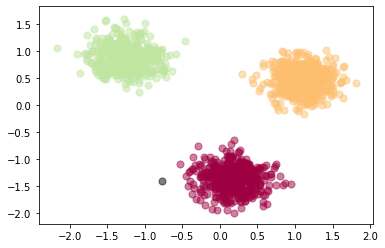

In [14]:
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

# Example with maps

### About the dataset

		
<h4 align = "center">
Environment Canada    
Monthly Values for July - 2015	
</h4>
<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}

tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>
<body>

<table>
  <tr>
    <th>Name in the table</th>
    <th>Meaning</th>
  </tr>
  <tr>
    <td><font color = "green"><strong>Stn_Name</font></td>
    <td><font color = "green"><strong>Station Name</font</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Lat</font></td>
    <td><font color = "green"><strong>Latitude (North+, degrees)</font></td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Long</font></td>
    <td><font color = "green"><strong>Longitude (West - , degrees)</font></td>
  </tr>
  <tr>
    <td>Prov</td>
    <td>Province</td>
  </tr>
  <tr>
    <td>Tm</td>
    <td>Mean Temperature (°C)</td>
  </tr>
  <tr>
    <td>DwTm</td>
    <td>Days without Valid Mean Temperature</td>
  </tr>
  <tr>
    <td>D</td>
    <td>Mean Temperature difference from Normal (1981-2010) (°C)</td>
  </tr>
  <tr>
    <td><font color = "black">Tx</font></td>
    <td><font color = "black">Highest Monthly Maximum Temperature (°C)</font></td>
  </tr>
  <tr>
    <td>DwTx</td>
    <td>Days without Valid Maximum Temperature</td>
  </tr>
  <tr>
    <td><font color = "black">Tn</font></td>
    <td><font color = "black">Lowest Monthly Minimum Temperature (°C)</font></td>
  </tr>
  <tr>
    <td>DwTn</td>
    <td>Days without Valid Minimum Temperature</td>
  </tr>
  <tr>
    <td>S</td>
    <td>Snowfall (cm)</td>
  </tr>
  <tr>
    <td>DwS</td>
    <td>Days without Valid Snowfall</td>
  </tr>
  <tr>
    <td>S%N</td>
    <td>Percent of Normal (1981-2010) Snowfall</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>P</font></td>
    <td><font color = "green"><strong>Total Precipitation (mm)</font></td>
  </tr>
  <tr>
    <td>DwP</td>
    <td>Days without Valid Precipitation</td>
  </tr>
  <tr>
    <td>P%N</td>
    <td>Percent of Normal (1981-2010) Precipitation</td>
  </tr>
  <tr>
    <td>S_G</td>
    <td>Snow on the ground at the end of the month (cm)</td>
  </tr>
  <tr>
    <td>Pd</td>
    <td>Number of days with Precipitation 1.0 mm or more</td>
  </tr>
  <tr>
    <td>BS</td>
    <td>Bright Sunshine (hours)</td>
  </tr>
  <tr>
    <td>DwBS</td>
    <td>Days without Valid Bright Sunshine</td>
  </tr>
  <tr>
    <td>BS%</td>
    <td>Percent of Normal (1981-2010) Bright Sunshine</td>
  </tr>
  <tr>
    <td>HDD</td>
    <td>Degree Days below 18 °C</td>
  </tr>
  <tr>
    <td>CDD</td>
    <td>Degree Days above 18 °C</td>
  </tr>
  <tr>
    <td>Stn_No</td>
    <td>Climate station identifier (first 3 digits indicate   drainage basin, last 4 characters are for sorting alphabetically).</td>
  </tr>
  <tr>
    <td>NA</td>
    <td>Not Available</td>
  </tr>


</table>

</body>
</html>

In [15]:
df = pd.read_csv('../Datasets/Week9/weather-stations20140101-20141231.csv')
df.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


In [16]:
df.shape

(1341, 25)

In [17]:
df = df[pd.notnull(df["Tm"])]
df = df.reset_index(drop=True)
df.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,8.0,NaN,NaN,12.0,NaN,NaN,NaN,258.6,0.0,1012710


In [18]:
df.shape

(1256, 25)

In [19]:
# if you dont have basemap install on your machine
# conda install -c conda-forge  basemap==1.1.0 -y


#import os
#os.environ['PROJ_LIB'] = r'C:\Users\<username>\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'


import os
os.environ['PROJ_LIB'] = r'C:\Users\TheGlitchCat\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

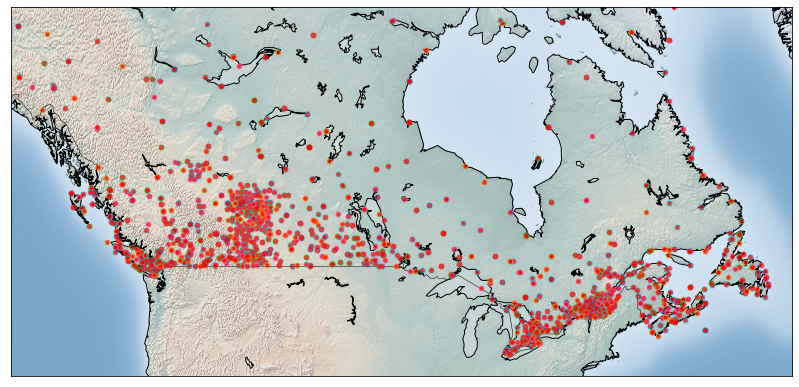

In [20]:
from mpl_toolkits.basemap import Basemap
from pylab import rcParams
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65

df = df[(df['Long'] > llon) & (df['Long'] < ulon) & (df['Lat'] > llat) &(df['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(df.Long), np.asarray(df.Lat))
df['xm']= xs.tolist()
df['ym'] =ys.tolist()

#Visualization1
for index,row in df.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()


### Clustering of stations based on their location i.e. Lat & Lon

__DBSCAN__ form sklearn library can runs DBSCAN clustering from vector array or distance matrix. In our case, we pass it the Numpy array Clus_dataSet to find core samples of high density and expands clusters from them. 

In [21]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df[['xm','ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
df[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


In [22]:
set(labels)

{-1, 0, 1, 2, 3, 4}

Cluster 0, Avg Temp: -5.538747553816051
Cluster 1, Avg Temp: 1.9526315789473685
Cluster 2, Avg Temp: -9.195652173913045
Cluster 3, Avg Temp: -15.300833333333333
Cluster 4, Avg Temp: -7.769047619047619


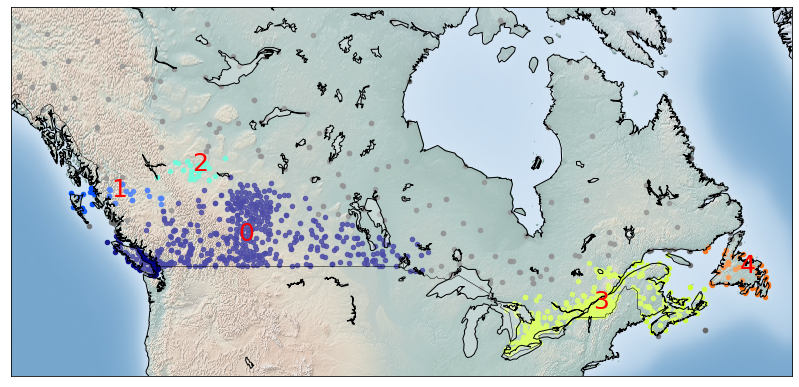

In [23]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df[df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

### Clustering of stations based on their location, mean, max, and min Temperature
In this section we re-run DBSCAN, but this time on a 5-dimensional dataset:

In [24]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df[['xm','ym','Tx','Tm','Tn']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
df[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


Cluster 0, Avg Temp: 6.2211920529801334
Cluster 1, Avg Temp: 6.790000000000001
Cluster 2, Avg Temp: -0.49411764705882355
Cluster 3, Avg Temp: -13.877209302325586
Cluster 4, Avg Temp: -4.186274509803922
Cluster 5, Avg Temp: -16.301503759398482
Cluster 6, Avg Temp: -13.599999999999998
Cluster 7, Avg Temp: -9.753333333333334
Cluster 8, Avg Temp: -4.258333333333334


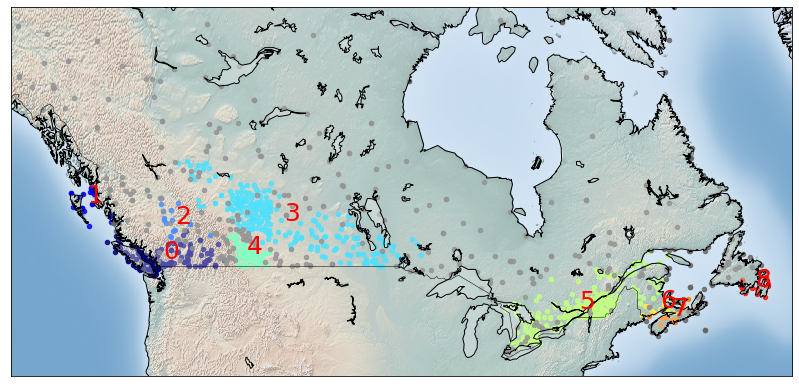

In [25]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df[df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

## Connectivity based methods - Agglomerative Clustering (Hierarchical)


See how we can build a k-neighbor connectivity matrix around any point.

In [26]:
X,_ = make_moons(500, noise=.1)

(-0.7639291639688053, 1.2789497153512652)

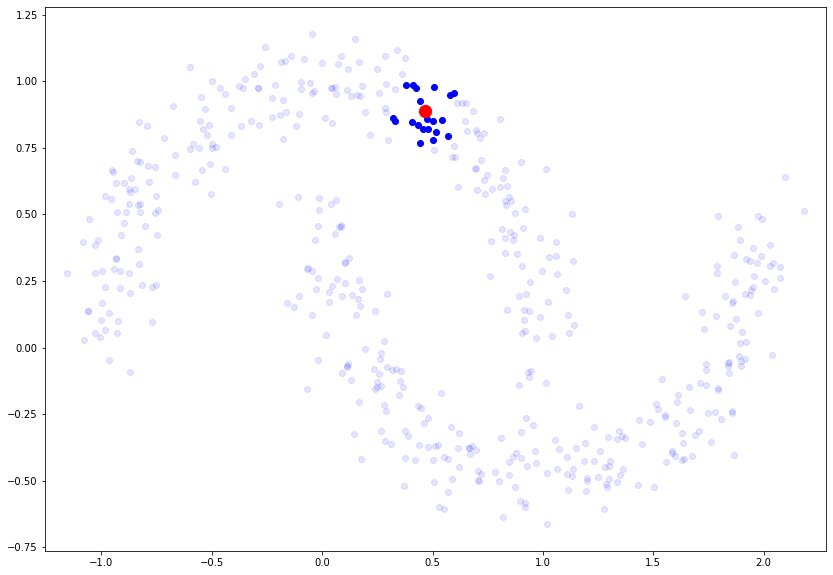

In [27]:
from sklearn.neighbors import kneighbors_graph
i = np.random.randint(len(X))
knn_graph = kneighbors_graph(X, 20, include_self=False)

nn = X[knn_graph[i].toarray()[0].astype(bool)]
plt.scatter(nn[:,0], nn[:,1], color="blue", alpha=1)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.1)
plt.scatter(X[i,0], X[i,1], s=150, color="red")
plt.xlim(np.min(X[:,0])-.1, np.max(X[:,0])+.1)
plt.ylim(np.min(X[:,1])-.1, np.max(X[:,1])+.1)

we use this connectivity matrix to supply structure information to the algorithm

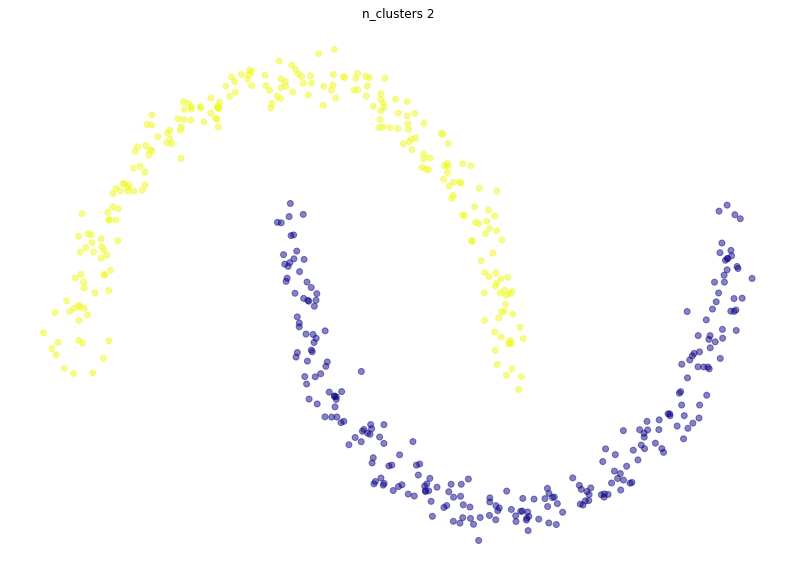

In [28]:
from sklearn.neighbors import kneighbors_graph
X,_ = make_moons(500, noise=.05)
knn_graph = kneighbors_graph(X, 20, include_self=False)
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")

plot_cluster_predictions(ac, X, n_clusters=2, cmap=plt.cm.plasma)

look at the response to different neighborhood sizes.

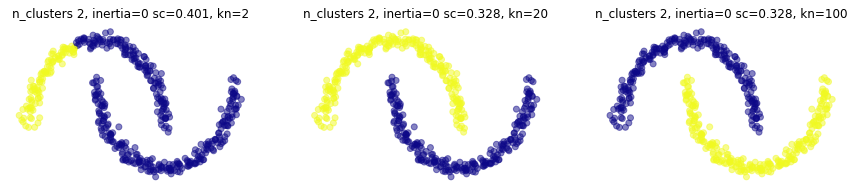

In [29]:
plt.figure(figsize=(15,3))
for i,kn in enumerate([2,20,100]):
    plt.subplot(1,3,i+1)
    knn_graph = kneighbors_graph(X, kn, include_self=False)
    plot_cluster_predictions(AgglomerativeClustering(connectivity=knn_graph, linkage="average"), X, 
                                     n_clusters=2, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", kn=%d"%kn)

and at different noise levels in the data set

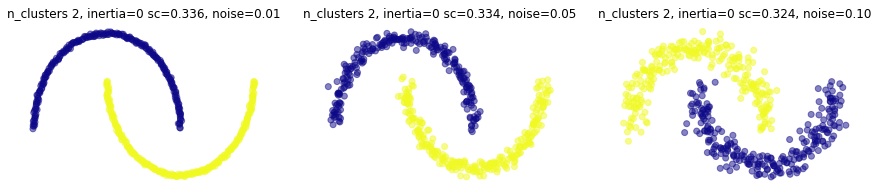

In [30]:
plt.figure(figsize=(15,3))
for i,noise in enumerate([.01,.05,.1]):
    plt.subplot(1,3,i+1)
    X,_ = make_moons(500, noise=noise)
    knn_graph = kneighbors_graph(X, 20, include_self=False)
    plot_cluster_predictions(AgglomerativeClustering(connectivity=knn_graph, linkage="average"), X, 
                                     n_clusters=2, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", noise=%.2f"%noise)

- See [dataset generation](http://scikit-learn.org/stable/modules/classes.html#samples-generator) in sklearn.
- See [comparing clustering](http://scikit-learn.org/0.18/auto_examples/cluster/plot_cluster_comparison.html) for synthetic datasets.

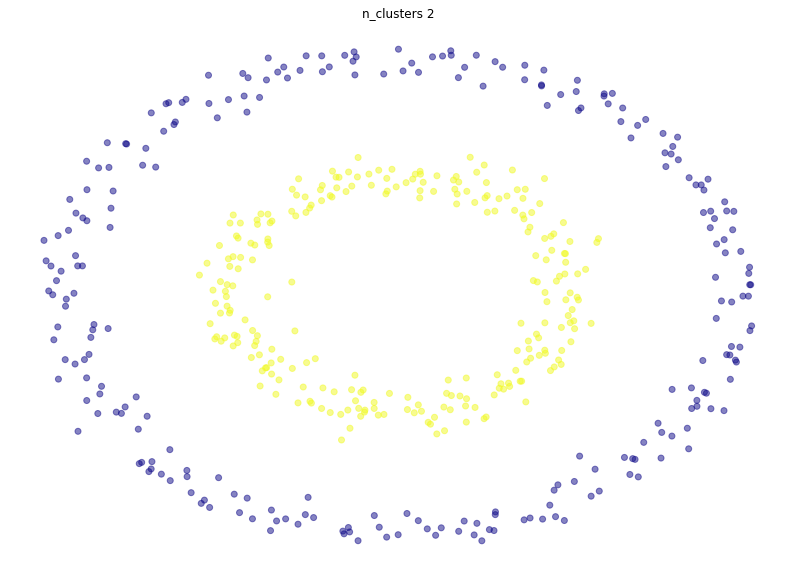

In [31]:
from sklearn import datasets
X,_ = datasets.make_circles(500, noise=.05, factor=.5)
knn_graph = kneighbors_graph(X, 10, include_self=False)
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")
plot_cluster_predictions(ac, X, n_clusters=2, cmap=plt.cm.plasma)

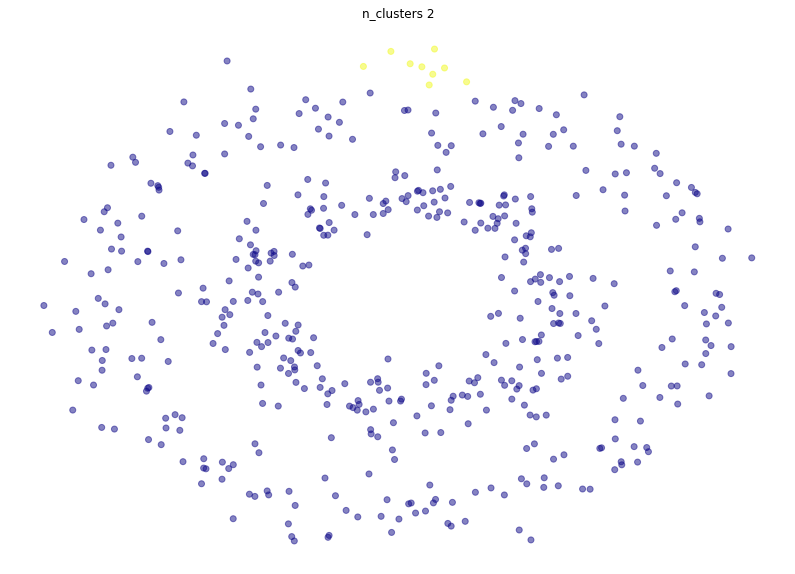

In [34]:
from sklearn import datasets
X,_ = datasets.make_circles(500, noise=.1, factor=.5)
knn_graph = kneighbors_graph(X, 50, include_self=False)
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")
plot_cluster_predictions(ac, X, n_clusters=2, cmap=plt.cm.plasma)

### Other Example

In [35]:
X1, y1 = make_blobs(n_samples=50, centers=[[4,4], [-2, -1], [1, 1], [10,4]], cluster_std=0.9)

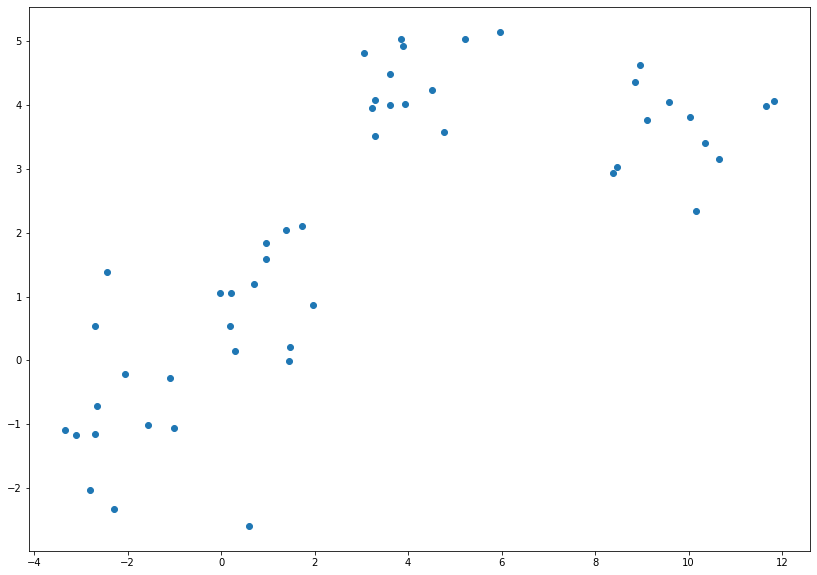

In [36]:
plt.scatter(X1[:, 0], X1[:, 1], marker='o') 

In [37]:
agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'average')

In [38]:
agglom.fit(X1,y1)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=4,
                        pooling_func='deprecated')

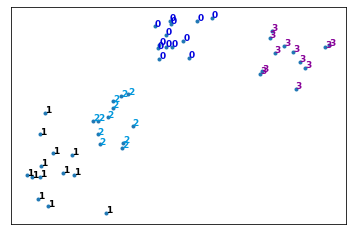

In [39]:
# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(6,4))

# These two lines of code are used to scale the data points down,
# Or else the data points will be scattered very far apart.

# Create a minimum and maximum range of X1.
x_min, x_max = np.min(X1, axis=0), np.max(X1, axis=0)

# Get the average distance for X1.
X1 = (X1 - x_min) / (x_max - x_min)

# This loop displays all of the datapoints.
for i in range(X1.shape[0]):
    # Replace the data points with their respective cluster value 
    # (ex. 0) and is color coded with a colormap (plt.cm.spectral)
    plt.text(X1[i, 0], X1[i, 1], str(y1[i]),
             color=plt.cm.nipy_spectral(agglom.labels_[i] / 10.),
             fontdict={'weight': 'bold', 'size': 9})
    
# Remove the x ticks, y ticks, x and y axis
plt.xticks([])
plt.yticks([])
#plt.axis('off')



# Display the plot of the original data before clustering
plt.scatter(X1[:, 0], X1[:, 1], marker='.')
# Display the plot
plt.show()

In [40]:
dist_matrix = distance_matrix(X1,X1) 
print(dist_matrix)

[[0.         0.71392472 0.34579207 ... 0.68892046 0.57187537 0.06282168]
 [0.71392472 0.         0.93162219 ... 0.0630169  0.23836104 0.66111444]
 [0.34579207 0.93162219 0.         ... 0.88844171 0.72571501 0.34875121]
 ...
 [0.68892046 0.0630169  0.88844171 ... 0.         0.17994884 0.63341254]
 [0.57187537 0.23836104 0.72571501 ... 0.17994884 0.         0.51119718]
 [0.06282168 0.66111444 0.34875121 ... 0.63341254 0.51119718 0.        ]]


In [41]:
Z = hierarchy.linkage(dist_matrix, 'complete')

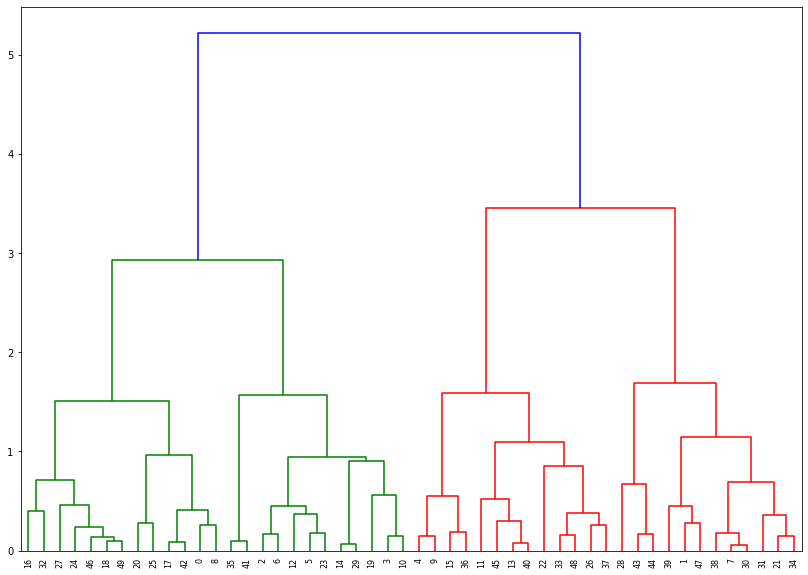

In [42]:
dendro = hierarchy.dendrogram(Z)

In [43]:
Z = hierarchy.linkage(dist_matrix, 'average')

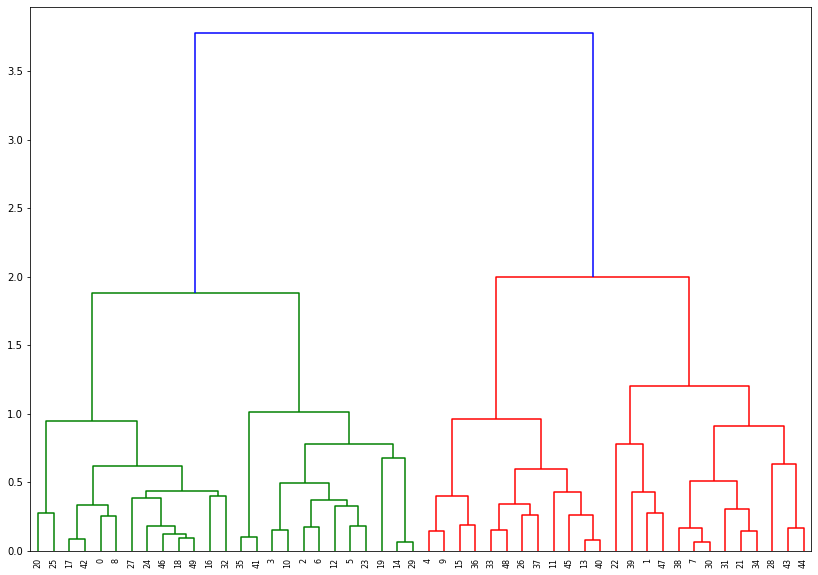

In [44]:
dendro = hierarchy.dendrogram(Z)

### Other dataset

In [45]:

df = pd.read_csv('../Datasets/Week9/cars_clus.csv')
print ("Shape of dataset: ", df.shape)

df.head(5)

Shape of dataset:  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


In [46]:
print ("Shape of dataset before cleaning: ", df.size)
df[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = df[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df = df.reset_index(drop=True)
print ("Shape of dataset after cleaning: ", df.size)
df.head(5)

Shape of dataset before cleaning:  2544
Shape of dataset after cleaning:  1872


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


In [47]:
featureset = df[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]

In [48]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

In [49]:
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

In agglomerative clustering, at each iteration, the algorithm must update the distance matrix to reflect the distance of the newly formed cluster with the remaining clusters in the forest. 
The following methods are supported in Scipy for calculating the distance between the newly formed cluster and each:
    - single
    - complete
    - average
    - weighted
    - centroid
    
    
We use __complete__ for our case, but feel free to change it to see how the results change.

In [50]:

Z = hierarchy.linkage(D, 'complete')

In [51]:
from scipy.cluster.hierarchy import fcluster
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 1,  5,  5,  6,  5,  4,  6,  5,  5,  5,  5,  5,  4,  4,  5,  1,  6,
        5,  5,  5,  4,  2, 11,  6,  6,  5,  6,  5,  1,  6,  6, 10,  9,  8,
        9,  3,  5,  1,  7,  6,  5,  3,  5,  3,  8,  7,  9,  2,  6,  6,  5,
        4,  2,  1,  6,  5,  2,  7,  5,  5,  5,  4,  4,  3,  2,  6,  6,  5,
        7,  4,  7,  6,  6,  5,  3,  5,  5,  6,  5,  4,  4,  1,  6,  5,  5,
        5,  6,  4,  5,  4,  1,  6,  5,  6,  6,  5,  5,  5,  7,  7,  7,  2,
        2,  1,  2,  6,  5,  1,  1,  1,  7,  8,  1,  1,  6,  1,  1],
      dtype=int32)

In [52]:
from scipy.cluster.hierarchy import fcluster
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters


array([1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3, 3, 2, 1,
       5, 3, 3, 3, 3, 3, 1, 3, 3, 4, 4, 4, 4, 2, 3, 1, 3, 3, 3, 2, 3, 2,
       4, 3, 4, 1, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 2, 2, 1, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 2,
       3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1,
       3, 4, 1, 1, 3, 1, 1], dtype=int32)

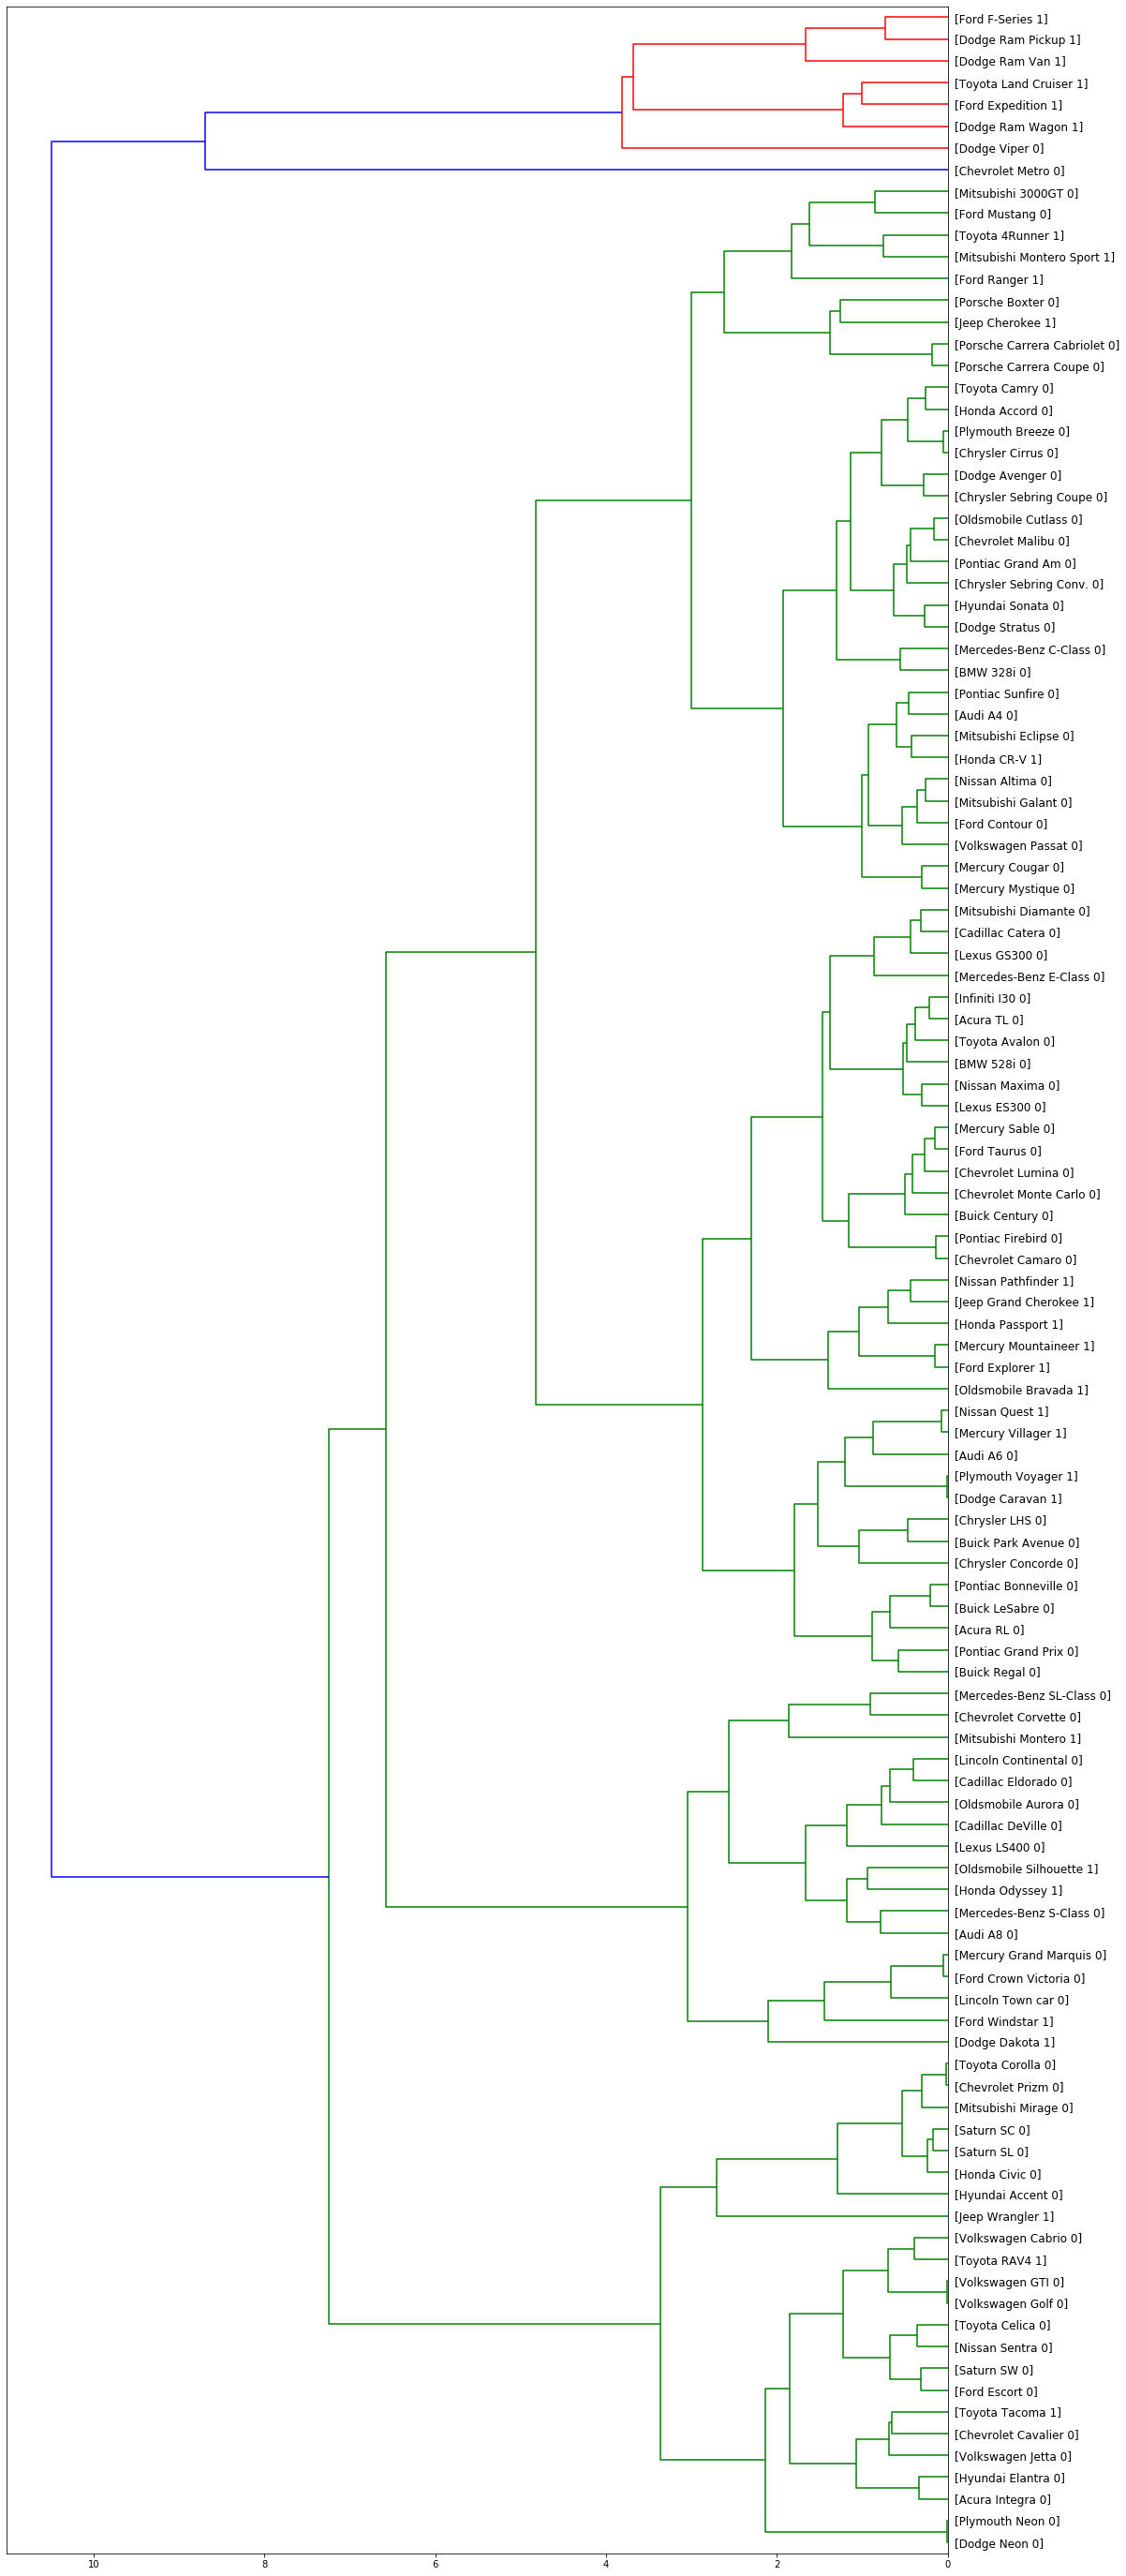

In [57]:
import pylab
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (df['manufact'][id], df['model'][id], int(float(df['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'left')

### Other dataset

In [58]:
dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
print(dist_matrix)

[[0.         0.57777143 0.75455727 ... 0.28530295 0.24917241 0.18879995]
 [0.57777143 0.         0.22798938 ... 0.36087756 0.66346677 0.62201282]
 [0.75455727 0.22798938 0.         ... 0.51727787 0.81786095 0.77930119]
 ...
 [0.28530295 0.36087756 0.51727787 ... 0.         0.41797928 0.35720492]
 [0.24917241 0.66346677 0.81786095 ... 0.41797928 0.         0.15212198]
 [0.18879995 0.62201282 0.77930119 ... 0.35720492 0.15212198 0.        ]]


In [59]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 5, 1,
       4, 1, 1, 2, 1, 2, 1, 1, 1, 5, 0, 0, 0, 3, 2, 1, 2, 1, 2, 3, 2, 3,
       0, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 2, 3, 2, 3, 1, 2, 3, 5, 1, 1, 2, 3, 2, 1, 3,
       2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1], dtype=int64)

In [60]:
df['cluster_'] = agglom.labels_
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,1
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,2
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,2
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,1
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,2


Text(0, 0.5, 'mpg')

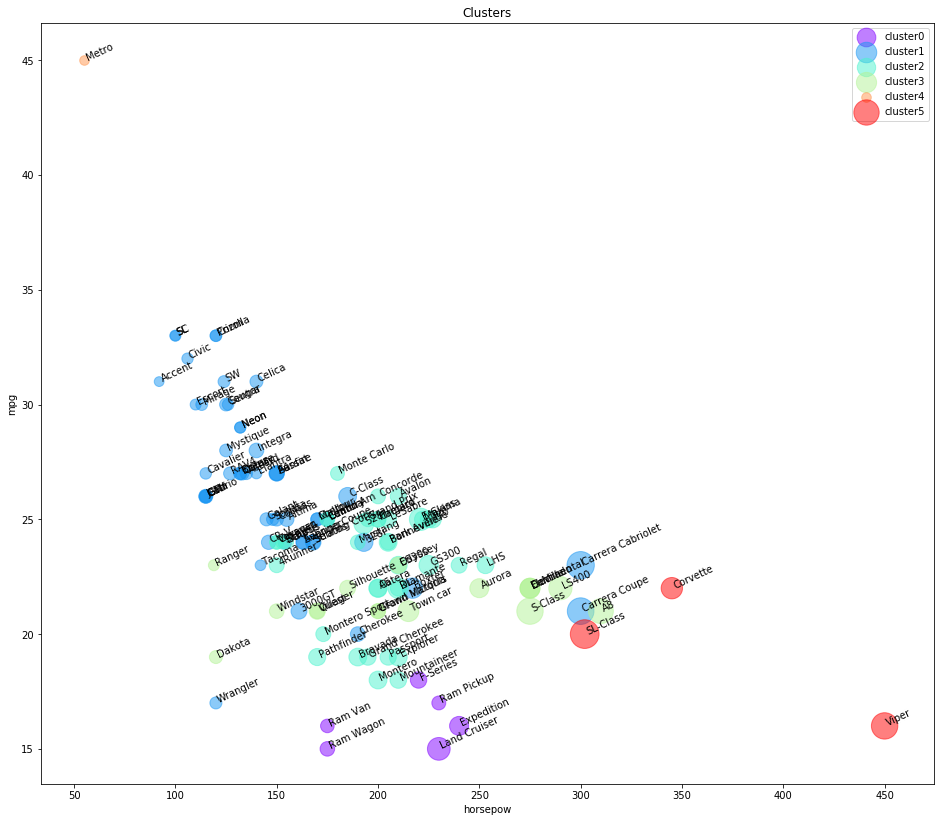

In [61]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = df[df.cluster_ == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, color=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

In [62]:
df.groupby(['cluster_','type'])['cluster_'].count()

cluster_  type
0         1.0      6
1         0.0     47
          1.0      5
2         0.0     27
          1.0     11
3         0.0     10
          1.0      7
4         0.0      1
5         0.0      3
Name: cluster_, dtype: int64

In [63]:
agg_cars = df.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()
agg_cars

horsepow  engine_s        mpg      price
cluster_ type                                            
0        1.0   211.666667  4.483333  16.166667  29.024667
1        0.0   146.531915  2.246809  27.021277  20.306128
         1.0   145.000000  2.580000  22.200000  17.009200
2        0.0   203.111111  3.303704  24.214815  27.750593
         1.0   182.090909  3.345455  20.181818  26.265364
3        0.0   256.500000  4.410000  21.500000  42.870400
         1.0   160.571429  3.071429  21.428571  21.527714
4        0.0    55.000000  1.000000  45.000000   9.235000
5        0.0   365.666667  6.233333  19.333333  66.010000


It is obvious that we have 3 main clusters with the majority of vehicles in those.

__Cars__:
- Cluster 1: with almost high mpg, and low in horsepower.
- Cluster 2: with good mpg and horsepower, but higher price than average.
- Cluster 3: with low mpg, high horsepower, highest price.
    
    
    
__Trucks__:
- Cluster 1: with almost highest mpg among trucks, and lowest in horsepower and price.
- Cluster 2: with almost low mpg and medium horsepower, but higher price than average.
- Cluster 3: with good mpg and horsepower, low price.


Please notice that we did not use __type__ , and __price__ of cars in the clustering process, but Hierarchical clustering could forge the clusters and discriminate them with quite high accuracy.

Text(0, 0.5, 'mpg')

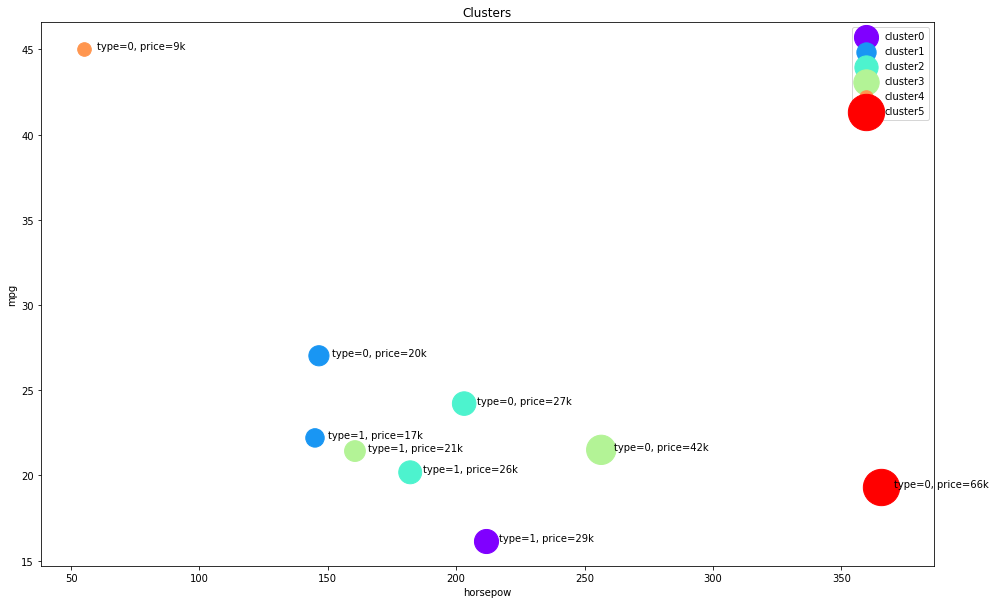

In [64]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, color=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')
